# CS 505 Homework 04:  Classification

#### Due Friday  10/27 at midnight (1 minute after 11:59 pm) in Gradescope (with a grace period of 6 hours)
#### You may submit the homework up to 24 hours late (with the same grace period) for a penalty of 10%. 

All homeworks will be scored with a maximum of 100 points; point values are given
for individual problems, and if parts of problems do not have point values given, they
will be counted equally toward the total for that problem. 

Note: I strongly recommend you work in **Google Colab** (the free version) to complete homeworks in this class; in addition to (probably) being faster than your laptop, all the necessary libraries will already be available to you, and you don't have to hassle with <code>conda</code>, <code>pip</code>, etc. and resolving problems when the install doesn't work. But it is up to you!   You should go through the necessary tutorials listed on the web site concerning Colab and storing files on a Google Drive. And of course, Dr. Google is always ready to help you resolve your problems. 

I will post a  "walk-through" video ASAP on my <a href="https://www.youtube.com/channel/UCfSqNB0yh99yuG4p4nzjPOA">Youtube Channel</a>. 

#### Submission Instructions

You must complete the homework by editing <b>this notebook</b> and submitting the following two files in Gradescope by the due date and time:

  - A file <code>HW04.ipynb</code> (be sure to select <code>Kernel -> Restart and Run All</code> before you submit, to make sure everything works); and
  - A file <code>HW04.pdf</code> created from the previous.
  
  For best results obtaining a clean PDF file on the Mac, select <code>File -> Print Review</code> from the Jupyter window, then choose <code>File-> Print</code> in your browser and then <code>Save as PDF</code>.  Something  similar should be possible on a Windows machine -- just make sure it is readable and no cell contents have been cut off. Make it easy to grade!
  
The date and time of your submission is the last file you submitted, so if your IPYNB file is submitted on time, but your PDF is late, then your submission is late. 

## Collaborators (5 pts)

Describe briefly but precisely

1. Any persons you discussed this homework with and the nature of the discussion;
2. Any online resources you consulted and what information you got from those resources; and
3. Any AI agents (such as chatGPT or CoPilot) or other applications you used to complete the homework, and the nature of the help you received. 

A few brief sentences is all that I am looking for here. 

1. In obtained some help from professor Snyder and Wenda in order to debug a couple issues.
2. Online resources like the linked site https://machinelearningmastery.com/develop-word-embeddings-python-gensim/ and documentations pages for Pytorch (https://pytorch.org/docs/stable/nn.html) were also somewhat useful. But I primary depending on Professor Snyder's Pytorch Lecture and Homework Walkthrough for reference.
3. Finally ChatGPT helped me with debugging some import issues (since I'm not using Collab), as well as helped me figure out how to dump my Notebook variables using Pickle (so I don't have to rerun everything every time). ChatGPT also helped me learn some numpy tricks to take the column mean of matrix using np.mean(reduced_matrix, axis=0).


In [1]:
import math
import os.path

import numpy as np
import spacy as spacy
from numpy.random import shuffle, seed, choice
from tqdm import tqdm
from collections import defaultdict, Counter
import pandas as pd
import re
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset,DataLoader
import torch.nn.functional as F
from torch.utils.data import random_split,Dataset,DataLoader
from torchvision import datasets, transforms
from torch import nn, optim

from torchvision.datasets import MNIST
import torchvision.transforms as T

from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import pickle


In [2]:
"""
This cell contains some helpful methods to dump notebook variables
to a file so you don't have to rerun expensive computations every
time.
"""

from typing import Union

def does_var_exists(var_name) -> bool:
    return os.path.isfile(F'./pickle/{var_name}.pkl')

def dump_var(var_name, obj) -> None:
    with open(F'./pickle/{var_name}.pkl', 'wb') as file:
        pickle.dump(obj, file)

def load_var(var_name) -> Union[None, object]:
    if not does_var_exists(var_name):
        return None
    with open(F'./pickle/{var_name}.pkl', 'rb') as file:
        return pickle.load(file)

In [3]:
# create directories where we will be storing data
os.makedirs('./models/players', exist_ok=True)
os.makedirs('./models/plays', exist_ok=True)
os.makedirs('./pickle', exist_ok=True)
os.makedirs('./trained_nn', exist_ok=True)
os.makedirs('./glove', exist_ok=True)

william-shakespeare-black-silhouette.png

## Problem One: Exploring Shakespeare's Plays with PCA (45 pts)

In this problem, we will use Principal Components Analysis to look at Shakespeare's plays, as
we discussed with a very different play/movie in lecture.  Along the way, we shall use the tokenizer and the TF-IDF vectorizer from `sklearn,`
a common machine learning library.

Note: There is a library for text analysis in Pytorch called `Torchtext`, however, in my view this will less well-developed and less well-supported than the rest of Pytorch, so we shall use `sklearn` for this problem. 

 

### Part A:  Reading and exploring the data (5 pts)

The cells below read in three files and convert them to `numpy` arrays (I prefer to work with the arrays rather than with `pandas` functions, but it is your choice).  

1. The file `shakespeare_plays.csv` contains lines from William Shakespeare’s plays. The second column of the file contains the name of
the play, the third the name of the player (or the indication `<Stage Direction>`, and the fourth
the line spoken: 

Screenshot%202023-10-14%20at%208.17.27%20AM.png


2. The file `play_attributes.csv` stores the genres and chronology of Shakepeare's plays; the first column is the name of the play, the second the genre, and the third its order in a chronological listing of when it was first performed. The plays are in the same (arbitrary) order as in the first file. 

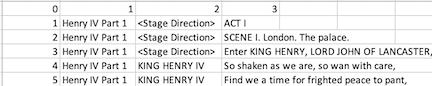

Screenshot%202023-10-14%20at%208.39.25%20AM.png
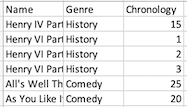


3. The file `player_genders.csv` stores the name of a major character (defined somewhat arbitrarily as one whose total lines contain more than 1400 characters) in the first column and their gender in the second. 



Screenshot%202023-10-14%20at%208.26.26%20AM.png
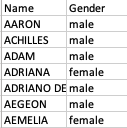

**To Do:**   For each of the arrays, print out the the `shape` and the first line. 


In [4]:
# download and locally save these arrays we aren't downloading them everytime

if does_var_exists('plays_array'):
    plays_array = load_var('plays_array')
else:
    plays_array : np.array = pd.read_csv('https://www.cs.bu.edu/fac/snyder/cs505/shakespeare_plays.csv').to_numpy()
    dump_var('plays_array', plays_array)


if does_var_exists('player_genders_array'):
    player_genders_array = load_var('player_genders_array')
else:
    player_genders_array : np.array = pd.read_csv('https://www.cs.bu.edu/fac/snyder/cs505/player_genders.csv').to_numpy()
    dump_var('player_genders_array', player_genders_array)


if does_var_exists('play_attributes_array'):
    play_attributes_array = load_var('play_attributes_array')
else:
    play_attributes_array : np.array = pd.read_csv('https://www.cs.bu.edu/fac/snyder/cs505/play_attributes.csv').to_numpy()
    dump_var('play_attributes_array', play_attributes_array)


In [5]:
for arr_name, arr in zip(['plays_array', 'player_genders_array', 'play_attributes_array'], [plays_array, player_genders_array, play_attributes_array]):
    # print shape
    print(F"Shape of {arr_name}: {arr.shape}")
    # print first line
    print(arr[0])

Shape of plays_array: (111582, 4)
[1 'Henry IV Part 1' '<Stage Direction>' 'ACT I']
Shape of player_genders_array: (398, 2)
['AARON' 'male']
Shape of play_attributes_array: (36, 3)
['Henry IV Part 1' 'History' 15]


### Part B: Visualizing the Plays (8 pts)

1. Create an array containing 36 strings, each being the concatenation of all lines spoken.   Be sure to NOT include stage directions!  You may wish to create an appropriate dictionary as an intermediate step. 

2. Create a document-term matrix where each row represents a play and each column represents a term used in that play. Each entry in this matrix represents the number of times a particular word (defined by the column) occurs in a particular play (defined by the row). Use `CountVectorizer` in `sklearn` to create the matrix. Keep the rows in the same order as in the original files in order to associate play names with terms correctly. 

3. From this matrix, use `TruncatedSVD` in `sklearn` to create a 2-dimensional representation of each play. Try to make it as similar as possible to the illustration below, including (i) appropriate title, (ii) names of each play, followed by its chronological order, and (iii) different colors for each genre. Use a `figsize` of `(8,8)` and a `fontsize` of `6` to provide the best visibility. You can follow the tutorial [here](https://machinelearningmastery.com/develop-word-embeddings-python-gensim/) to create the visualization (look at the "PCA" part).

4. Now do the same thing all over again, but with TF-IDF counts (using `TFIDFVectorizer` in `sklearn`). 


5. Answer the following in a few sentences:  What plays are similar to each other? Do they match the grouping of Shakespeare’s plays into comedies, histories, and tragedies here?  Which plays are outliers (separated from the others in the same genre)?  Did one of TF or TF-IDF provided the best insights?


Screenshot%202023-10-14%20at%209.09.20%20AM.png
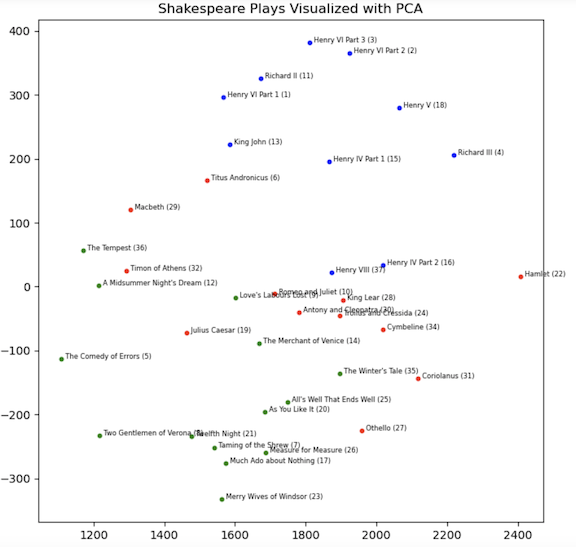

In [6]:
from typing import Dict

# Play -> Lines in the Play Dictionary
play_lines_dict : Dict[str, str] = defaultdict(lambda: '')

i = 0
j = 0
for (_, play, character, line) in plays_array:
    # if its a stage direction, increment counter and countinue loop
    if character == '<Stage Direction>':
        continue
    if play_lines_dict[play] != '':
        play_lines_dict[play] += ' ' # append a ' ' unless its the start of the string
    play_lines_dict[play] += line

In [7]:
# the 36 strings array
play_string_array = []
for play in play_lines_dict:
    play_string_array += [play_lines_dict[play]]

In [8]:
# Check if word_use_matrix exists in the store
if does_var_exists('word_use_matrix'):
    # If it exists, load the previously saved version
    word_use_matrix = load_var('word_use_matrix')
else:
    # If it doesn't exist, create and save it
    count_vectorizer = CountVectorizer()
    word_use_matrix = count_vectorizer.fit_transform(play_string_array)
    dump_var('word_use_matrix', word_use_matrix)

In [9]:
if does_var_exists('truncated_matrix'):
    truncated_matrix = load_var('truncated_matrix')
else:
    pca = TruncatedSVD(n_components=2)
    truncated_matrix = pca.fit_transform(word_use_matrix)
    dump_var('truncated_matrix', truncated_matrix)

In [10]:
play_chronological = play_attributes_array[:,2]
play_genres = play_attributes_array[:,1]
genre_to_numbers = {}
play_genre_as_numbers = []
i = 0
for genre in play_genres:
  if genre in genre_to_numbers:
    continue
  genre_to_numbers[genre] = i
  i += 1
for genre in play_genres:
    play_genre_as_numbers += [genre_to_numbers[genre]]

<Figure size 800x800 with 0 Axes>

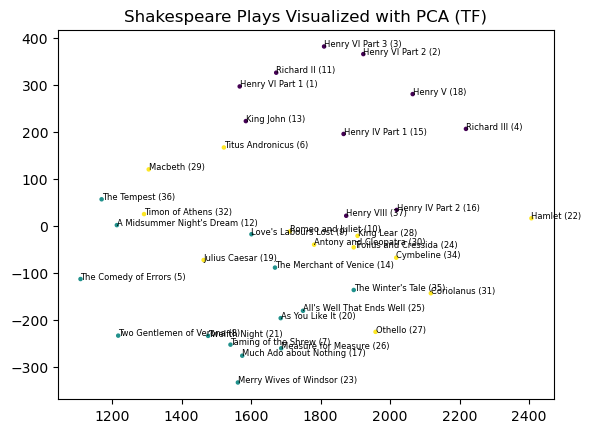

<Figure size 800x800 with 0 Axes>

In [11]:
plt.title("Shakespeare Plays Visualized with PCA (TF)")
X, Y = (truncated_matrix[:,0], truncated_matrix[:,1])
plt.scatter(X, Y, c=play_genre_as_numbers, s=5)
for play,i in zip(play_lines_dict.keys(), range(len(play_lines_dict.keys()))):
    plt.annotate(F"{play} ({play_chronological[i]})", xy=(X[i], Y[i]), fontsize=6)
plt.figure(figsize=(8, 8))

In [12]:
# Check if word_use_matrix exists in the store
if does_var_exists('tfidf_matrix'):
    # If it exists, load the previously saved version
    tfidf_matrix = load_var('tfidf_matrix')
else:
    # If it doesn't exist, create and save it
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(play_string_array)
    dump_var('tfidf_matrix', tfidf_matrix)

In [13]:
pca = TruncatedSVD(n_components=2)
result = pca.fit_transform(tfidf_matrix)

<Figure size 800x800 with 0 Axes>

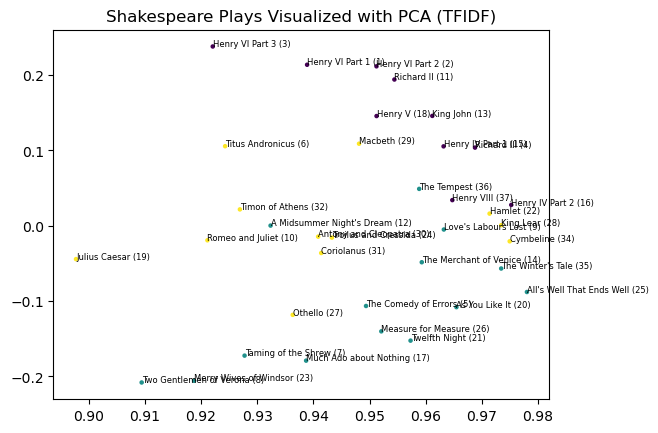

<Figure size 800x800 with 0 Axes>

In [14]:
plt.title("Shakespeare Plays Visualized with PCA (TFIDF)")
X, Y = (result[:,0], result[:,1])
plt.scatter(X, Y, c=play_genre_as_numbers, s=5)
for play,i in zip(play_lines_dict.keys(), range(len(play_lines_dict.keys()))):
    plt.annotate(F"{play} ({play_chronological[i]})", xy=(X[i], Y[i]), fontsize=6)
plt.figure(figsize=(8, 8))

**Comments and Observations**:
With both TF and TF-IDF the plays do indeed cluster into their genres, however, TF-IDF looks a little less scattered and messy and seems to have more structure to it. Some outliers include Othello, The Tempest, A Midsummer Night's Dream and their irregular behavior seems to be visible in both graphs (but much more clearly in TF-IDF).

### Part C: Visualizing the Players (8 pts)

Now you must repeat this same kind of visualization, but instead of visualizing plays, you must visualize players.
The process will be essentially the same, starting with an array of strings representing the lines spoken by each player. Use one of TF or TF-IDF, and use different colors for the genders. 

Use a figsize of (8,8) and a fontsize of 4 to make this a bit more visible. 

Again, comment on what you observe (it will not be as satisfying as the previous part).

In [15]:
player_names = player_genders_array[:,0]
player_genders = player_genders_array[:,1]
players_set = set(player_names) # because sets are fast :)

In [16]:
players_lines_dict : Dict[str, str] = defaultdict(lambda: '')

i = 0
j = 0
for (_, play, character, line) in plays_array:
    # if its a stage direction, increment counter and countinue loop
    if character == '<Stage Direction>':
        continue
    # if this player is a rando, skip
    if character not in players_set:
        continue
    if players_lines_dict[character] != '':
        players_lines_dict[character] += ' ' # append a ' ' unless its the start of the string
    players_lines_dict[character] += line

In [17]:
player_string_array = []
for player in players_lines_dict:
    player_string_array += [players_lines_dict[player]]

In [18]:
# Check if word_use_matrix exists in the store
if does_var_exists('word_use_matrix_players'):
    # If it exists, load the previously saved version
    word_use_matrix_players = load_var('word_use_matrix_players')
else:
    # If it doesn't exist, create and save it
    count_vectorizer = CountVectorizer()
    word_use_matrix_players = count_vectorizer.fit_transform(player_string_array)
    dump_var('word_use_matrix_players', word_use_matrix_players)

In [19]:
if does_var_exists('truncated_matrix_players'):
    truncated_matrix_players = load_var('truncated_matrix_players')
else:
    pca = TruncatedSVD(n_components=2)
    truncated_matrix_players = pca.fit_transform(word_use_matrix_players)
    dump_var('truncated_matrix_players', truncated_matrix_players)

In [20]:
player_gender_dict = {}
for i in range(len(player_names)):
  player_gender_dict[player_names[i]] = player_genders[i]
player_genders_as_numbers = [player_gender_dict[x] == 'male' for x in players_lines_dict.keys()]

<Figure size 800x800 with 0 Axes>

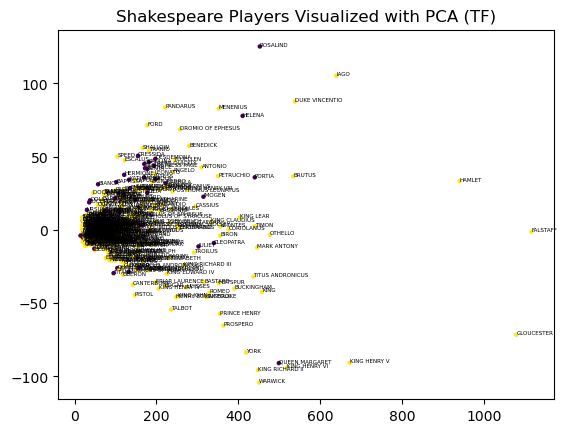

<Figure size 800x800 with 0 Axes>

In [21]:
plt.title("Shakespeare Players Visualized with PCA (TF)")
X, Y = (truncated_matrix_players[:,0], truncated_matrix_players[:,1])
plt.scatter(X, Y, c=player_genders_as_numbers, s=5)
for player,i in zip(players_lines_dict.keys(), range(len(players_lines_dict.keys()))):
    plt.annotate(F"{player}", xy=(X[i], Y[i]), fontsize=4)
plt.figure(figsize=(8, 8))

**Comments and Observations**:
It seems that both male and females ended talked very similarly in Shakespear's plays. There is no apparent pattern unlike the previous part between how the characters talk and their gender but it seems that a disproportionate amount of the female characters ended up in the top half of the graph. In any case there does seem to be SOME pattern with a triangular shape that spreads out as seen above though I don't believe that pattern is correlated to the character genders..

### Part D:  DIY Word Embeddings (8 pts)

In this part you will create a word-word matrix where each row (and each column) represents a word in the vocabulary.
Each entry in this matrix represents the number of times a particular word (defined by the row) co-occurs with another
word (defined by the column) in a sentence (i.e., line in `plays`). Using the row word vectors, create a document-term matrix which represents
a play as the average of all the word vectors in the play. 

Display the plays using `TruncatedSVD` as you did previously.  

Again, comment on what you observe: how different is this from the first visualization?

**Notes:**  

1. Remove punctuation marks .  ,  ;  :  ?  ! but leave single quotes. 
2. One way to proceed is to create a nested dictionary mapping each word to a dictionary of the frequency of words that occur in the same line, then from this to create the sparse matrix which is used to create the average document-term matrix which is input to `TruncatedSVD`.
3. If you have trouble with the amount of memory necessary, you may wish to eliminate "stop words" and then isolate some number (say, 5000) of the remaining most common words, and build your visualization on that instead of the complete vocabulary. 


In [22]:
cleaned_play_lines_dict = defaultdict(lambda: []) # For use in 1D and 1E
cleaned_character_lines_dict = defaultdict(lambda: []) # For use in 1F
for (_, play, character, line) in plays_array:
    # if its a stage direction, increment counter and countinue loop
    if character == '<Stage Direction>':
        continue
    # clean the line up
    line = re.sub("[-.,:;?!\"]", "", line) # remove punctuations (prof. said to remove the dash too)
    line = line.lower() # put everything in lower case
    # add the line to a cleaned line list
    cleaned_play_lines_dict[play] += [line]
    if character in players_set: # skip randos
        cleaned_character_lines_dict[character] += [line]

In [23]:
# before starting the counter create a superset containing every single word from every single play
# otherwise we will run in trouble when trying to make the matrix
if does_var_exists('all_words'):
    all_words = load_var('all_words')
else:
    all_words = set()
    for play in cleaned_play_lines_dict:
        for line in cleaned_play_lines_dict[play]:
            words = line.split(' ')
            all_words = all_words.union(set(words))
    dump_var('all_words', all_words)

In [24]:
# now count the frequency of each word, we will use this info to calculate the DIY embeddings
play_word_freq_dict = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: 0)))

for play in cleaned_play_lines_dict:
    for word in all_words:
        play_word_freq_dict[play][word][word] = 0

for play in cleaned_play_lines_dict:
    for line in cleaned_play_lines_dict[play]:
        words = line.split(' ')
        for word in words:
            for other_word in words:
                # skip self
                if other_word == word:
                    continue
                # increment counter
                play_word_freq_dict[play][word][other_word] += 1

In [25]:
# convert each play into a row vector by averaging term frequencies
word_embedded_matrix_list = []
for play in play_word_freq_dict:
    word_freq_dict_current_play = play_word_freq_dict[play] # a dict of the CURRENT play
    word_to_avg = {}
    for word in all_words:
        cnt = 0
        for neighbor_word in word_freq_dict_current_play[word]:
            cnt += word_freq_dict_current_play[word][neighbor_word]
        cnt /= len(word_freq_dict_current_play) # divide by the total number of words across the CURRENT play
        word_to_avg[word] = cnt # words not in this play will have a count of 0
    row_vector = list(word_to_avg.values())
    # make sure the length of this row vector should be the same as the total num of words
    # if its not we are doing something wrong and won't be able to combine these into a matrix
    assert len(row_vector) == len(all_words)
    word_embedded_matrix_list += [row_vector]
# convert the 2d list into a real matrix
word_embedded_matrix = np.array(word_embedded_matrix_list)

In [26]:
if does_var_exists('truncated_matrix_word_embeddings'):
    truncated_matrix_word_embeddings = load_var('truncated_matrix_word_embeddings')
else:
    pca = TruncatedSVD(n_components=2)
    truncated_matrix_word_embeddings = pca.fit_transform(word_embedded_matrix)
    dump_var('truncated_matrix_word_embeddings', truncated_matrix_word_embeddings)

<Figure size 800x800 with 0 Axes>

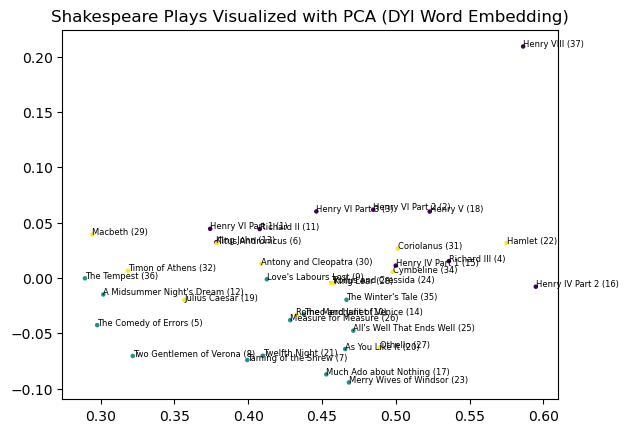

<Figure size 800x800 with 0 Axes>

In [27]:
plt.title("Shakespeare Plays Visualized with PCA (DYI Word Embedding)")
X, Y = (truncated_matrix_word_embeddings[:,0], truncated_matrix_word_embeddings[:,1])
plt.scatter(X, Y, c=play_genre_as_numbers, s=5)
for play,i in zip(play_lines_dict.keys(), range(len(play_lines_dict.keys()))):
    plt.annotate(F"{play} ({play_chronological[i]})", xy=(X[i], Y[i]), fontsize=6)
plt.figure(figsize=(8, 8))

**Comments and Observations:**

This time around, there seems to be a layered structure to the clusters with historical plays on the top, followed by tragedies and comedies. One blatant outlier here is Henry VIII which interesting was not an outlier in the previous graphs. But similar to the previous graph, the comedies ended up in the "middle" section of the layering pattern here.

### Part E:  Visualizing the Plays using Word2Vec Word Embeddings (8 pts)

Now we will do the play visualization using word embeddings created by Gensim's `Word2Vec`, which can create word embeddings just as you did in the previous part, but using better algorithms. 

You can read about how to use `Word2Vec` and get template code here:

https://radimrehurek.com/gensim/models/word2vec.html

I strongly recommend you follow the directions for creating the model, then using `KeyedVectors` to
avoid recomputing the model each time. 

Experiment with the `window` (say 5) and the `min_count` (try in the range 1 - 5) parameters to get the best results. 

Display the plays using `PCA` instead of `TruncatedSVD`.  

Again, comment on what you observe: how different is this from the other visualizations?


In [28]:
from gensim.models import Word2Vec, KeyedVectors

# a control variable to avoid regenerating the model on every run
GENERATE_NEW_MODEL_EVERY_TIME = True

play_to_models = {}

for play in cleaned_play_lines_dict:
    try:
        if GENERATE_NEW_MODEL_EVERY_TIME:
            raise FileNotFoundError # manually trigger the error to generate new stuff
        wv_model = KeyedVectors.load(F"models/plays/{play}.wv", mmap='r')
    except FileNotFoundError:
        split_string_sentences = [sentence.split(' ') for sentence in cleaned_play_lines_dict[play]]
        model = Word2Vec(sentences=split_string_sentences, window=3, min_count=2)
        wv_model = model.wv
        wv_model.save(F"models/plays/{play}.wv")
    play_to_models[play] = wv_model

In [29]:
full_word2vec_play_matrix = []
for play in cleaned_play_lines_dict:
    key_vec: KeyedVectors = play_to_models[play]
    word_matrix = np.array([key_vec[word] for word in key_vec.index_to_key])
    pca = PCA(n_components=2)
    reduced_matrix = pca.fit_transform(word_matrix)
    column_averages = np.mean(reduced_matrix, axis=0)
    full_word2vec_play_matrix += [column_averages]
full_word2vec_play_matrix = np.array(full_word2vec_play_matrix)

<Figure size 800x800 with 0 Axes>

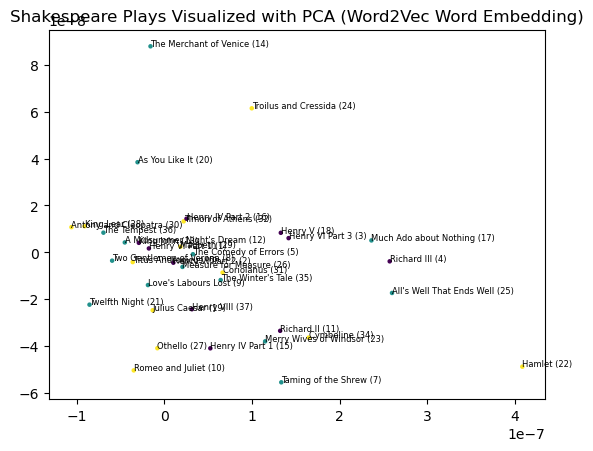

<Figure size 800x800 with 0 Axes>

In [30]:
plt.title("Shakespeare Plays Visualized with PCA (Word2Vec Word Embedding)")
X, Y = (full_word2vec_play_matrix[:,0], full_word2vec_play_matrix[:,1])
plt.scatter(X, Y, c=play_genre_as_numbers, s=5)
for play,i in zip(cleaned_play_lines_dict.keys(), range(len(cleaned_play_lines_dict.keys()))):
    plt.annotate(F"{play} ({play_chronological[i]})", xy=(X[i], Y[i]), fontsize=6)
plt.figure(figsize=(8, 8))

**Comments and Observations:**
I tried playing around with window and min_count sizes but no pattern seems to emerge no matter what I do. Unlike the previous visualizations, the graph in this visualization seems totally random with relation to the genre and where the play ends up on the embedding. Still, we have to realize, that projection a multi-dimensional embedding to only 2D space, might be deleting a lot of information. My guess is, if there was some pattern, it must have been lost in the dimensionality reduction...

### Part F:  Visualizing the Players using Word2Vec Word Embeddings (8 pts)

Now you must repeat Part C, but using these `Word2Vec` embeddings. 

Use a figsize of (8,8) and a fontsize of 4 to make this a bit more visible. 

Again, comment on what you observe. How is this different from what you saw in Part C?


In [31]:
# a control variable to avoid regenerating the model on every run
GENERATE_NEW_MODEL_EVERY_TIME_2 = True

player_to_models = {}

for player in cleaned_character_lines_dict:
    try:
        if GENERATE_NEW_MODEL_EVERY_TIME_2:
            raise FileNotFoundError # manually trigger the error to generate new stuff
        wv_model = KeyedVectors.load(F"models/players/{player}.wv", mmap='r')
    except FileNotFoundError:
        split_string_sentences = [sentence.split(' ') for sentence in cleaned_character_lines_dict[player]]
        model = Word2Vec(sentences=split_string_sentences, window=3, min_count=2)
        wv_model = model.wv
        wv_model.save(F"models/players/{player}.wv")
    player_to_models[player] = wv_model

In [32]:
full_word2vec_player_matrix = []
for play in cleaned_character_lines_dict:
    key_vec: KeyedVectors = player_to_models[play]
    # get the np vector of each word and make a matrix out of it
    word_matrix = np.array([key_vec[word] for word in key_vec.index_to_key])
    pca = PCA(n_components=2)
    reduced_matrix = pca.fit_transform(word_matrix)
    column_averages = np.mean(reduced_matrix, axis=0)
    full_word2vec_player_matrix += [column_averages]
full_word2vec_player_matrix = np.array(full_word2vec_player_matrix)

<Figure size 800x800 with 0 Axes>

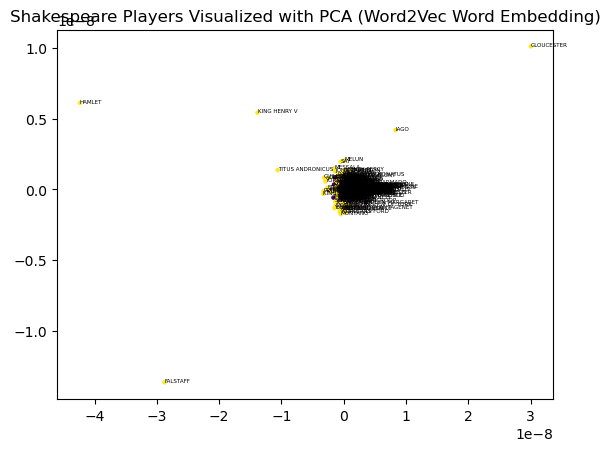

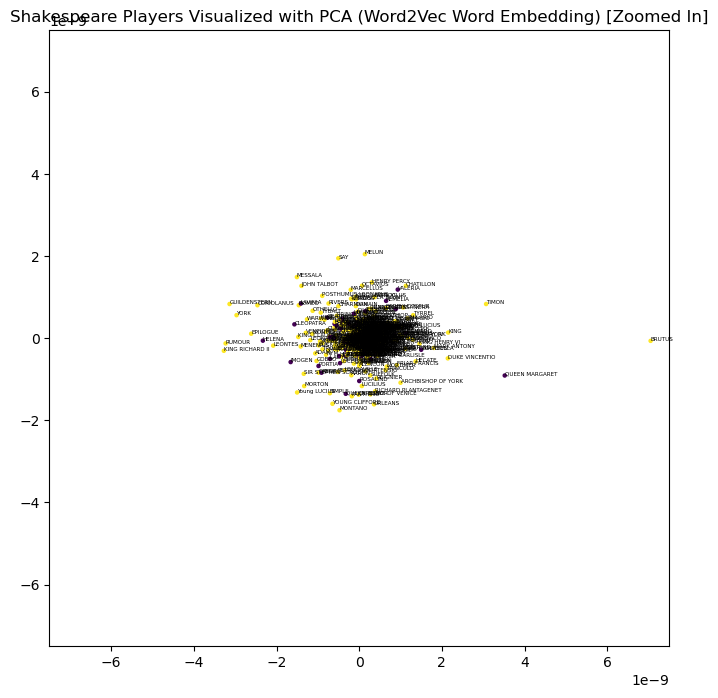

<Figure size 800x800 with 0 Axes>

In [33]:
X, Y = (full_word2vec_player_matrix[:,0], full_word2vec_player_matrix[:,1])

plt.title("Shakespeare Players Visualized with PCA (Word2Vec Word Embedding)")
plt.scatter(X, Y, c=player_genders_as_numbers, s=5)
for player,i in zip(cleaned_character_lines_dict.keys(), range(len(cleaned_character_lines_dict.keys()))):
    plt.annotate(F"{player}", xy=(X[i], Y[i]), fontsize=4)
plt.figure(figsize=(8, 8))

# zoomed in version
plt.title("Shakespeare Players Visualized with PCA (Word2Vec Word Embedding) [Zoomed In]")
plt.scatter(X, Y, c=player_genders_as_numbers, s=5)
for player,i in zip(cleaned_character_lines_dict.keys(), range(len(cleaned_character_lines_dict.keys()))):
    plt.annotate(F"{player}", xy=(X[i], Y[i]), fontsize=4)
plt.xlim(-7.5E-9, 7.5E-9)
plt.ylim(-7.5E-9, 7.5E-9)
plt.figure(figsize=(8, 8))

**Comments and Observations:**
Despite trying multiple window_sizes and min_count sizes, it seems just like the last plot, all the characters are clustered together near each other with no apparent pattern between their genders and where the ended on the graph. Moreover, characters like Hamlet, Gloucester and Falstaff continue to be outliers. However, unlike the last graph where there was still some kind of pattern with data points spewing out towards the right, this time there is no similar pattern. Perhaps this shouldn't be so surprising considering Shakespeare, a single person, wrote all of these characters.

## Problem Two: Classifying Text with a Feed-Forward Neural Network (50 pts)


In this problem, you must create a FFNN in Pytorch to classify emails from the Enron dataset as to whether they
are spam or not spam ("ham"). For this problem, we will use `Glove` pretrained embeddings. The dataset
and the embeddings are in the following location:

https://drive.google.com/drive/folders/1cHR4VJuuN2tEpSkT3bOaGkOJrvIV-lSR?usp=sharing

(You can also download the embeddings yourself from the web; but the dataset is one created
just for this problem.)

### Part A: Prepare the Data (10 pts)

Compute the features of the emails (the vector of 100 floats input to the NN) vector based on the average value of the word vectors that belong to the words in it.

Just like the previous problem, we compute the 'representation' of each message, i.e. the vector, by averaging word vectors; but this time, we are using [Glove word embeddings](https://nlp.stanford.edu/projects/glove/) instead. Specifically, we are using word embedding 'glove.6B.100d' to obtain word vectors of each message, as long as the word is in the 'glove.6B.100d' embedding space.

Here are the steps to follow:

1. Have a [basic idea](https://nlp.stanford.edu/pubs/glove.pdf) of how Glove provides pre-trained word embeddings (vectors).
2. Download and extract word vectors from 'glove.6B.100d'. 
3. Tokenize the messages ( `spacy` is a good choice) and compute the message vectors by averaging the vectors of words in the message. You will need to test if a word is in the model (e.g., something like ` if str(word) in glove_model ...`) and ignore any words which have no embeddings.

In [34]:
from gensim.scripts.glove2word2vec import glove2word2vec
import os

# Note: I just wanted to try using the 50, 100, and 200 dimension embeddings to see
# the result

embedding_to_try = 200 # whether to try the 50d, 100d or 200d embedding
# ^^ prof. Snyder says its ok to try the 200D embedding instead of the 100d one
glove_dataset_dir = F'./glove/glove.6B.{embedding_to_try}d.txt'
glove_output_vec_dir = F'./glove/glove.6B.{embedding_to_try}d.wv'
if not os.path.isfile(glove_output_vec_dir):
    glove2word2vec(glove_dataset_dir, glove_output_vec_dir)

In [35]:
# this actually takes a while so ill save the result
if does_var_exists(F'glove_model_{embedding_to_try}'):
    glove_model = load_var(F'glove_model_{embedding_to_try}')
else:
    glove_model = KeyedVectors.load_word2vec_format(glove_output_vec_dir, binary=False)
    dump_var(F'glove_model_{embedding_to_try}', glove_model)

In [36]:
enron_data_dir = './enron_spam_ham.csv'
emails_raw = pd.read_csv(enron_data_dir).to_numpy()

In [37]:
if does_var_exists(F'full_emails_matrix_{embedding_to_try}'):
    full_emails_matrix = load_var(F'full_emails_matrix_{embedding_to_try}')
else:
    spacy.require_gpu() # I got a GPU so Ima take advantage of it :)
    sp = spacy.load('en_core_web_sm') # we want the english tokenizer
    all_emails = emails_raw[:,0]
    full_emails_matrix = []
    for doc in sp.pipe(all_emails, batch_size=200):
        doc_matrix_array = []
        for word in doc:
            # if word has embedding...
            if str(word) in glove_model:
                vector = glove_model[str(word)]
                doc_matrix_array += [vector]
        # average out the matrix
        doc_matrix = np.array(doc_matrix_array)
        column_averages = np.mean(doc_matrix, axis=0)
        full_emails_matrix += [column_averages]
    full_emails_matrix = np.array(full_emails_matrix)
    dump_var(F'full_emails_matrix_{embedding_to_try}', full_emails_matrix)


### Part B: Create the DataLoader (15 pts)

Now you must separate the data set into training, validation, and testing sets, and build a 'Dataset' and 'DataLoader' for each that can feed data to train your model with Pytorch.

Use a train-validation-test split of 80%-10%-10%. You can experiment with different batch sizes, starting with 64.

Hints:
1. Make sure `__init__` , `__len__` and `__getitem__` of the your defined dataset are implemented properly. In particular, the `__getitem__` should return the specified message vector and its label.
2. Don't compute the message vector when calling the `__getitem__` function, otherwise the training process will slow down A LOT. Calculate these in an array before creating the data loader in the next step.
3. The data in the `.csv` is randomized, so you don't need to shuffle when doing the split.

In [38]:
#device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu' # gpu training for some reason was very slow ^^

In [39]:
class EmailDataSet(Dataset):

        full_emails_matrix_dataset = None

        def __init__(self):
            self.full_emails_matrix_dataset = full_emails_matrix

        def __len__(self):
            return len(self.full_emails_matrix_dataset)

        def __getitem__(self, idx):
            return (self.full_emails_matrix_dataset[idx], emails_raw[:,1][idx])

In [40]:
email_dataset: EmailDataSet = EmailDataSet()
gen = torch.Generator().manual_seed(0)  # this will ensure the same split every time
train_emails_ds, val_emails_ds,test_emails_ds = random_split(email_dataset, [0.8,0.1,0.1], generator=gen)

esd : EmailDataSet = train_emails_ds.dataset

batch_size = 50
emails_training_dataloader =   DataLoader(train_emails_ds, batch_size=batch_size, shuffle=True)
emails_validation_dataloader = DataLoader(val_emails_ds,   batch_size=batch_size, shuffle=True)
emails_testing_dataloader =    DataLoader(test_emails_ds,  batch_size=batch_size, shuffle=True)

### Part C:  Build the neural net model (25 pts)

Once the data is ready, we need to design and implement our neural network model.

The model does not need to be complicated. An example structure could be:

1. linear layer 100 x 15
2. ReLU activation layer
3. linear layer 15 x 2

But feel free to test out other possible combinations of linear layers & activation function and whether they make significant difference to the model performance later.

In order to perform "early stopping," you must keep track of the best validation score as you go through the epochs, and
save the best model generated so far; then use the model which existed when the validation score
was at a minimum to do the testing. (This could also be the model which is deployed, although we won't
worry about that.) Read about `torch.save(...)` and `torch.load(...)` to do this.

Experiment with different batch sizes and optimizers and learning rates to get the best validation
score for the model you create with early stopping. (Try not to look *too hard* at the final accuracy!) Include your final performance charts (using `show_performance_curves`) when you submit.

Conclude with a brief analysis (a couple of sentences is fine) relating what experiments you did,
and what choices of geometry, optimizer, learning rate, and batch size gave you the best results.
It should not be hard to get well above 90% accuracy on the final test.

In [41]:
def show_performance_curves(training_loss,validation_loss,training_accuracy,validation_accuracy,test_accuracy, best_epoch):

    plt.figure(figsize=(5, 3))
    plt.plot(training_loss,label='Training',color='g')
    plt.plot(validation_loss,label='Validation',color='b')
    plt.axvline(x=best_epoch, color='red', linestyle='--', label="Best Epoch")
    plt.title('Training and Validation Loss')
    plt.legend(loc='upper right')
#     plt.ylim(-0.1,(max(max(training_loss),max(validation_loss))*1.1) )
    plt.grid()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

    print('Final Training Loss:  ',np.around(training_loss[-1],6))
    print('Final Validation Loss:',np.around(validation_loss[-1],6))

    plt.figure(figsize=(5, 3))
    plt.plot(training_accuracy,label='Training',color='g')
    plt.plot(validation_accuracy,label='Validation',color='b')
    plt.axvline(x=best_epoch, color='red', linestyle='--', label="Best Epoch")
    plt.title('Training and Validation Accuracy')
    plt.legend(loc='lower right')
#     plt.ylim(-0.1,1.1)
    plt.grid()
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.show()

    print('Final Training Accuracy:  ',np.around(training_accuracy[-1],6))
    print('Final Validation Accuracy:',np.around(validation_accuracy[-1],6))
    print()

    print("Test Accuracy:", np.around(test_accuracy.item(),4))

    print()

In [42]:
class EmailsModel(nn.Module):

        # We first define a number of local variables for layers

        def __init__(self):
            super(EmailsModel,self).__init__()
            self.hidden_layer1 = nn.Linear(embedding_to_try,21)
            self.hidden_layer2 = nn.Linear(21,7)
            self.hidden_layer3 = nn.Linear(7,2)

        # foward defines the forward pass of a FFNN,
        # sending a vector x through each layer and then returning it

        def forward(self,x):

            x = self.hidden_layer1(x)
            x = F.relu(x)
            x = self.hidden_layer2(x)
            x = F.relu(x)
            x = self.hidden_layer3(x)
            return x

In [43]:
emails_model = EmailsModel().to(device)
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(emails_model.parameters(),lr=0.03)

In [44]:
N_train,N_val,N_test = len(train_emails_ds),len(val_emails_ds),len(test_emails_ds)

num_epochs = 500

training_losses = np.zeros(num_epochs)
val_losses      = np.zeros(num_epochs)

training_accuracy = np.zeros(num_epochs)
val_accuracy      = np.zeros(num_epochs)

# train and validate
for epoch in tqdm(range(num_epochs)):
    # training
    emails_model.train()
    t_loss = 0.0
    t_num_correct = 0

    for X_train_batch,Y_train_batch in emails_training_dataloader:
        X_train_batch = X_train_batch.to(device)                     # <<====
        Y_train_batch = Y_train_batch.to(device)
        optimizer.zero_grad()
        Y_train_hat = emails_model(X_train_batch)
        loss = loss_fn(Y_train_hat,Y_train_batch)
        loss.backward()
        optimizer.step()
        t_loss += loss.item()

        # If we just use the scalar class number, it must be a long (we did this when creating the dataset)
        t_num_correct += (torch.argmax(Y_train_hat,dim=1) == Y_train_batch).float().sum()

    training_losses[epoch]   = t_loss/N_train
    training_accuracy[epoch] = t_num_correct/N_train

    #  validation
    v_loss = 0.0
    emails_model.eval()
    v_num_correct = 0

    for X_val_batch,Y_val_batch in emails_validation_dataloader:
        X_val_batch = X_val_batch.to(device)                     # <<====
        Y_val_batch = Y_val_batch.to(device)                     # <<====

        Y_hat_val = emails_model(X_val_batch)
        loss = loss_fn(Y_hat_val,Y_val_batch)
        v_loss += loss.item()

        v_num_correct += (torch.argmax(Y_hat_val,dim=1) == Y_val_batch).float().sum()

    val_losses[epoch]   = v_loss/N_val
    val_accuracy[epoch] = v_num_correct/N_val

    # save our NN every 5 iterations
    if (epoch + 1) % 5 == 0:
        torch.save(emails_model, F"./trained_nn/emails_epoch_{epoch}.nn")

100%|██████████| 500/500 [05:22<00:00,  1.55it/s]


In [45]:
#  testing
num_correct_test = 0
emails_model.eval()

for X_test_batch,Y_test_batch in emails_testing_dataloader:
    X_test_batch = X_test_batch.to(device)                     # <<====
    Y_test_batch = Y_test_batch.to(device)                     # <<====

    Y_hat_test = emails_model(X_test_batch)

    num_correct_test += (torch.argmax(Y_hat_test,dim=1) == Y_test_batch).float().sum()

test_accuracy = num_correct_test / N_test

In [46]:
# Look at our saved NNs (we saved every 5 iterations) and
# find the best epoch, and load the best NN
max_accuracy = 0
max_index = -1
for index in range(4, num_epochs, 5):
    current_accuracy = val_accuracy[index]
    if current_accuracy > max_accuracy:
        max_accuracy = current_accuracy
        max_index = index
print(F"The best validation occurred at epoch {max_index} with a validation of {val_accuracy[max_index]}")

# load back in the best network
best_emails_model = torch.load(F"./trained_nn/emails_epoch_{max_index}.nn")

The best validation occurred at epoch 289 with a validation of 0.98152095079422


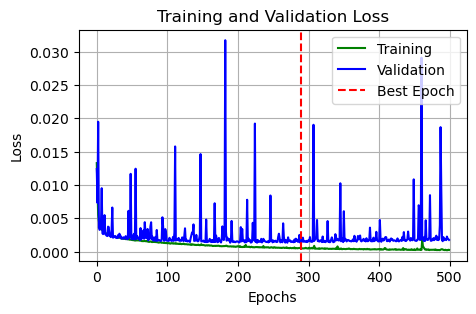

Final Training Loss:   0.000247
Final Validation Loss: 0.001742


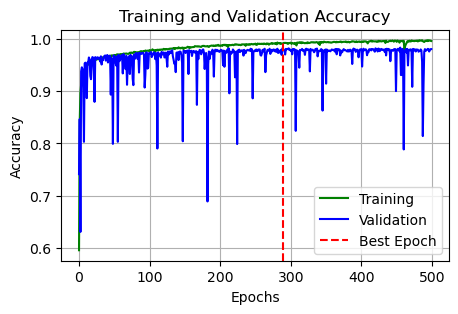

Final Training Accuracy:   0.995913
Final Validation Accuracy: 0.980455

Test Accuracy: 0.9812



In [47]:
show_performance_curves(training_losses,val_losses,training_accuracy,val_accuracy,test_accuracy, max_index)

Adam, Adagrad, and RMSprop were much slower than SGD without any noticable improvements as far as I tested. So in my final network, I just went with SGD. Higher batch sizes and learning rate definitely trained faster at a (small) cost in accuracy, so I had to find a middle ground. MOST networks I tried had very similar success around 92-96 range. It was very hard to get anything better. I tried wide networks, deep networks and always had roughly similar success and therefore it's hard to make generalizations about what's best. But what made the difference to reach 98%+ accuracy was using the 200D Word Embeddings instead of the 100D (though some tweaking to the network was still needed after that).